https://essay.utwente.nl/65559/1/vanderBlonk_MSc_EEMCS.pdf#page55

In [1]:
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting, LagrangesMethod, Lagrangian
from sympy.physics import mechanics
init_vprinting()

import numpy as np
import math
from time import time, sleep

In [2]:
def hat(v):
    a, b, c = v
    return Matrix([[0, -c, b], [c, 0, -a], [-b, a, 0]])

def Ad(H):
    R = H[:3, :3]
    o = H[:3, 3]
    Z = zeros(3)
    ans = [[R, Z], [hat(o) @ R, R]]
    return Matrix(ans)

def Hinv(H):
    R = H[:3, :3]
    p = H[:3, 3]
    z = Matrix(np.zeros((1, 3)))
    return Matrix([[R.T, -R.T @ p], [z, Matrix([1])]])

def jacobian(v, dq):
    n = len(v)
    m = len(dq)
    ans = np.zeros((n, m), dtype=object)
    
    zeros_slist = [(var, 0) for var in dq]
    for i in range(n):
        for j in range(m):
            ans[i, j] = v[i].subs(dq[j], 1).subs(zeros_slist)
    return Matrix(ans)

def partial(arg, x):
    lst = []
    for v in x:
        lst.append(arg.diff(v))
    return Matrix([lst])

In [3]:
Z = Matrix(np.zeros((3,3)))
I = eye(3)
get_w = Matrix([[I, Z]])
get_v = Matrix([[Z, I]])

In [4]:
# Variables
q = Matrix(dynamicsymbols("x y phi_x phi_y phi_z"))
t = symbols("t")
x, y, phix, phiy, phiz = q
dq = q.diff(t)
dx, dy, dphix, dphiy, dphiz = dq
T1, T2, T3 = symbols("Tau_1:4")

if False:
    # Parameters
    l, mb, mh = symbols("l m_b m_h")
    rb, rw = symbols("r_b r_w")
    g = symbols('g')
    alpha = symbols("alpha") # Angle of the omhiwheel point of contact from vertical (45 degrees)
    Ih = diag(*symbols("I_xx I_yy I_zz"))
    Iow, Im, k = symbols("I_ow I_m k")
    
    # Moment of Inertia (placeholder)
    Ib = diag(*([mb*rb**2]*3))
    
else:
    l = 0.169                      # Distance from ball COM to hat COM (m)
    ms = 0.624                     # Mass of ball (kg)
    mb = 2                         # Mass of body (kg)
    rs = 0.254 / 2                 # Radius of ball (m)
    rw = 0.096/2                   # Radius of wheel (m)
    g = 9.8                        # m/s^2
    alpha = rad(45)                # Angle of omniwheel axis from the horizontal plane (rad)
    Ib = diag(1.167e-2, 1.153e-2, 1.234e-2) # Inertia tensor of the body kg m^2
    Iow = 1/2*(96e-3)*rw**2        # Inertia of the wheel (scalar) kg m^2
    Im = 1/2*(0.2)*(32e-3 / 2)**2  # Inertia of the motor winding (scalar) kg m^2 (very rough estimate)
    k = 13.7                       # Gear ratio of the motor
    
    Is = diag(*[2/3*ms*rs**2]*3)
    
    # # Paper Parameters
    # ms = 3.2
    # mow = 0.555
    # mgh = 0.16
    # mm = 0.24
    # rs = 0.115
    # wb = 0.2
    # h = 0.8
    # h1 = 0.66
    # h2 = 0.14
    # Is = diag(*([2.65e-2]*3))
    # Im = 2.42e-6
    # Iow = 6.94e-5
    # l = 0.405
    # g = 9.81
    # alpha = math.radians(45)
    # beta = 0
    
    # mb = 10
    # mb1 = 6.2
    # mb2 = 0.935
    # mb2tot = 3.8
    # rw = 0.050
    # Ib = diag(8.76e-1, 8.76e-1, 6.67e-2)
    
    # # Not specified
    # k=10

    

In [5]:
# Coordinate Transformations
# Frame I: Innertial frame
# Frame 2: Origin at center of the ball
# Frame 5: Origin at COM of the robot body with axes aligned to the robot
HI1 = Matrix([[1, 0, 0, -x],[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
H12 = Matrix([[1, 0, 0, 0], [0, 1, 0, -y], [0, 0, 1, 0], [0, 0, 0, 1]])
H23 = Matrix([[cos(phiz), sin(phiz), 0, 0], [-sin(phiz), cos(phiz), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
H34 = Matrix([[cos(phiy), 0, sin(phiy), 0], [0, 1, 0, 0], [-sin(phiy), 0, cos(phiy), 0], [0, 0, 0, 1]]) # Flipped sign of sin(phiy)s
H45 = Matrix([[1, 0, 0, 0], [0, cos(phix), -sin(phix), 0], [0, sin(phix), cos(phix), -l], [0, 0, 0, 1]])

# Trig Simplifications
# HI1 = Matrix([[1, 0, 0, -x],[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
# H12 = Matrix([[1, 0, 0, 0], [0, 1, 0, -y], [0, 0, 1, 0], [0, 0, 0, 1]])
# H23 = Matrix([[1, phiz, 0, 0], [-phiz, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
# H34 = Matrix([[1, 0, phiy, 0], [0, 1, 0, 0], [-phiy, 0, 1, 0], [0, 0, 0, 1]])
# H45 = Matrix([[1, 0, 0, 0], [0, 1, -phix, 0], [0, phix, 1, -l], [0, 0, 0, 1]])


# HI2 = HI1 @ H12
# HI3 = HI2 @ H23
# HI4 = HI3 @ H34
# HI5 = HI4 @ H45

HI2 = H12 * HI1
HI3 = H23 * HI2
HI4 = H34 * HI3
HI5 = H45 * HI4

In [6]:
T2II = Matrix([0, 0, 0, dx, dy, 0])
T22I = Ad(HI2) @ T2II

v22I = get_v @ T22I

T25I = Ad(HI5) @ T2II

In [7]:
oI5 = HI5[:3,3]
RI5 = HI5[:3,:3]

v2II = Matrix([dx, dy, 0])
w2II = Matrix([0]*3)

v25I = hat(oI5)@RI5@w2II + RI5 @ v2II


rt = Matrix([0, 0, rs])
rt.cross(v22I) / (rt.T*rt)[0] # Checking derivation of wS2I

⎡-7.8740157480315⋅ẏ⎤
⎢                  ⎥
⎢7.8740157480315⋅ẋ ⎥
⎢                  ⎥
⎣        0         ⎦

In [8]:
wS2I = Matrix([-dy/rs, dx/rs, 0]) # Swapped the minus sign to match above derivation

In [9]:
w433 = Matrix([0, 1, 0])
w544 = Matrix([-1, 0, 0])

R43 = Hinv(H34)[:3,:3]
hat(w433) * R43*Matrix([0, 0, l])

⎡0.169⋅cos(φ_y)⎤
⎢              ⎥
⎢      0       ⎥
⎢              ⎥
⎣0.169⋅sin(φ_y)⎦

In [10]:
# Body Velocities
T1II = Matrix([0, 0, 0, 1, 0, 0])
T211 = Matrix([0, 0, 0, 0, 1, 0])
T322 = Matrix([0, 0, 1, 0, 0, 0])
T433 = Matrix([0, 1, 0, l, 0, 0])
T544 = Matrix([-1, 0, 0, 0, l, 0]) # CHECK THIS LINE
J = Matrix([[T1II, Ad(Hinv(HI1))@T211, Ad(Hinv(HI2))@T322, Ad(Hinv(HI3))@T433, Ad(Hinv(HI4))@T544]])

qJdot = Matrix([dx, dy, dphiz, dphiy, dphix])

T5II = J @ qJdot # Body Twist
T55I = Ad(HI5) @ T5II

In [11]:
# Omni Wheel Velocities
# Wheel 1 is on the positive x axis, with the other second wheel at +120 degrees and the third wheel at +240 degrees

H25 = H23 @ H34 @ H45
R25 = H25[:3, :3]

w55I = get_w @ T55I # angular velocity of Frame 5 wrt Frame I expressed in Frame 5

wS55 = R25 @ wS2I - w55I # wS55 is the angular velocity of the ball with respect to the body frame

rw1 = rs * Matrix([sin(alpha), 0, cos(alpha)])
rw2 = rs * Matrix([-sin(alpha)/2, sqrt(3)/2*sin(alpha), cos(alpha)])
rw3 = rs * Matrix([-sin(alpha)/2, -sqrt(3)/2*sin(alpha), cos(alpha)])

half = Rational(1, 2)
uw1 = Matrix([0, 1, 0])
uw2 = Matrix([-sqrt(3)/2, -half, 0])
uw3 = Matrix([sqrt(3)/2, -half, 0])

sw1 = (hat(wS55)@rw1).T @ uw1 / rw
sw2 = (hat(wS55)@rw2).T @ uw2 / rw
sw3 = (hat(wS55)@rw3).T @ uw3 / rw

In [12]:
# Ball Energies
RI2 = HI2[:3, :3]
H2I = Hinv(HI2)
wSII = get_w @ Ad(H2I) @ Matrix([wS2I, v22I])
Ts = T22I.T @ diag(Is, ms*I) @ T22I / 2 + wS2I.T@Is@wS2I / 2
Vs = 0

In [13]:
# Body Energies
R5I = Hinv(HI5)[:3, :3]
Tb = T55I.T @ diag(Ib, ms*eye(3)) @ T55I / 2
Vb = mb * Matrix([0,0,g]).T @ R5I @ Matrix([0, 0, l])

In [14]:
# Omniwheel Energies
Tws = (Iow + Im*k**2)/2 * (sw1**2 + sw2**2 + sw3**2)
Vws = 0

In [15]:
# Lagrangian
L = Ts[0] + Tb[0] + Tws[0] - (Vs + Vb[0] + Vws)

In [16]:
# Torque Transformations
jac = partial(Matrix([sw1, sw2, sw3]), dq) # from sw1, sw2, sw3
T_ext = jac.T @ Matrix([T1, T2, T3])

In [17]:
t0 = time()
LM = LagrangesMethod(L, q)
_ = LM.form_lagranges_equations()
print("Took %.1f seconds"%(time() - t0))

Took 44.8 seconds


# Linearization

In [18]:
xvar = Matrix([q, dq])
u = Matrix([T1, T2, T3])

xbar_slist = [(v, 0) for v in xvar] + [(v, 0) for v in u]

In [19]:
Mlin = LM.mass_matrix.subs(xbar_slist)
Mlin = np.array(Mlin, dtype=float).round(5)
Minv = np.linalg.inv(Mlin).round(3)

In [20]:
t0 = time()
# dG = np.array(partial(LM.forcing, xvar).subs(xbar_slist).doit(), dtype=float).round(5)

Glin_sp = -LM.forcing.subs([(v, 0) for v in (list(dq) + list(dq.diff(t)))])
dG = np.array(partial(Glin_sp, xvar).subs(xbar_slist).doit(), dtype=float).round(3)

print("Took %.2f seconds" %(time()-t0))

Took 9.41 seconds


In [21]:
Eq(Mlin @ dq.diff(t), Matrix(dG.round(2))[:,:5] @ q)

⎡0.0077⋅φ_̈y + 3.26408⋅ẍ⎤   ⎡    0    ⎤
⎢                      ⎥   ⎢         ⎥
⎢0.0077⋅φₓ̈ + 3.26408⋅ÿ ⎥   ⎢    0    ⎥
⎢                      ⎥   ⎢         ⎥
⎢0.10877⋅φₓ̈ + 0.0077⋅ÿ ⎥ = ⎢-3.31⋅φₓ ⎥
⎢                      ⎥   ⎢         ⎥
⎢0.10863⋅φ_̈y + 0.0077⋅ẍ⎥   ⎢-3.31⋅φ_y⎥
⎢                      ⎥   ⎢         ⎥
⎣     0.06396⋅φ_̈z      ⎦   ⎣    0    ⎦

In [22]:
Abot = Minv @ -dG

dT_ext = np.array(partial(T_ext, u).subs(xbar_slist).doit(), dtype=float).round(5)
Bbot = Minv @ dT_ext

In [23]:
A = np.vstack([np.hstack([np.zeros((5,5)), np.eye(5)]), Abot])
B = np.vstack([np.zeros((5,3)), Bbot])

Matrix(A.round(4)), Matrix(B.round(5))

⎛⎡0  0     0        0     0  1.0   0    0    0    0 ⎤  ⎡    0          0      
⎜⎢                                                  ⎥  ⎢                      
⎜⎢0  0     0        0     0   0   1.0   0    0    0 ⎥  ⎢    0          0      
⎜⎢                                                  ⎥  ⎢                      
⎜⎢0  0     0        0     0   0    0   1.0   0    0 ⎥  ⎢    0          0      
⎜⎢                                                  ⎥  ⎢                      
⎜⎢0  0     0        0     0   0    0    0   1.0   0 ⎥  ⎢    0          0      
⎜⎢                                                  ⎥  ⎢                      
⎜⎢0  0     0        0     0   0    0    0    0   1.0⎥  ⎢    0          0      
⎜⎢                                                  ⎥, ⎢                      
⎜⎢0  0     0     -0.0729  0   0    0    0    0    0 ⎥  ⎢    0      -3.93952   
⎜⎢                                                  ⎥  ⎢                      
⎜⎢0  0  -0.0729     0     0   0    0    0    0    0 

# Kalman Filter and LQR

In [24]:
import control
from control.matlab import obsv

In [25]:
xvar.T

[x  y  φₓ  φ_y  φ_z  ẋ  ẏ  φₓ̇  φ_̇y  φ_̇z]

In [26]:
# Gyroscope measurements of angular rates
C1 = np.hstack([np.zeros((3, 7)), np.eye(3)])
# Wheel Speed Measurements: Linearized jacobian of wheel speed
C2 = np.hstack([np.zeros((3,5)), np.array(jac.subs(xbar_slist), dtype=float)])
# Gyroscope measurements of gravity vector. Does this need a D-matrix?
C3 = np.hstack([np.zeros((3,2)), np.eye(3), np.zeros((3, 5))])
C = np.vstack([C1, C2, C3])

O = obsv(A, C)
print("Rank of obervability matrix is:", np.linalg.matrix_rank(O))
print("Missing observations are x and y position (duh)")

Rank of obervability matrix is: 8
Missing observations are x and y position (duh)


In [27]:
# Kalman Filter:
G = np.eye(8)
Qn = np.diag([1, 1, 1, 2, 2, 2, 2, 2]) # System model noise
Rn = np.diag([1, 1, 1, 2, 2, 2, 5, 5, 5]) * 10 # Sensor noise

L_kf_small, _, E_kf = control.lqe(A[2:,2:], G, C[:,2:], Qn, Rn)
L_kf = np.zeros((10, 9))
L_kf[:2, :] = L_kf_small
AK = A - L_kf @ C

In [28]:
max_pos_error = np.array([0.5, 0.5, np.deg2rad(10), np.deg2rad(10), np.pi])
Q = np.diag(list(1/max_pos_error) + list(1/(max_pos_error*3)))**2
R = np.diag([3.5]*3) * 1

K_lqr, _, E_lqr = control.lqr(A, B, Q, R)

In [29]:
Matrix(K_lqr.round(3))

⎡  0     0.873   2.195     0     -0.058    0     3.837   -0.121    0     -0.02
⎢                                                                             
⎢-0.756  -0.436  -1.097  -1.901  -0.058  -3.325  -1.919   0.06   0.105   -0.02
⎢                                                                             
⎣0.756   -0.436  -1.097  1.901   -0.058  3.325   -1.919   0.06   -0.105  -0.02

6⎤
 ⎥
6⎥
 ⎥
6⎦

In [43]:
K_str = "float K[30] = " + str(K_lqr.round(5).flatten().tolist()).replace('[', '{').replace(']', '}') + ";"

AKF_str = "float AKF[100] = " + str(AK.round(5).flatten().tolist()).replace('[', '{').replace(']', '}') + ";"
BKF_str = "float BKF_bot[15] = " + str(B[5:,:].round(5).flatten().tolist()).replace('[', '{').replace(']', '}') + ";"
LKF_str = "float LKF[90] = " + str(L_kf.round(5).flatten().tolist()).replace('[', '{').replace(']', '}') + ";"

In [44]:
K_str

'float K[30] = {0.0, 0.87287, 2.19488, 0.0, -0.05769, -0.0, 3.83731, -0.12086, 0.0, -0.02551, -0.75593, -0.43644, -1.09744, -1.90126, -0.05769, -3.32477, -1.91866, 0.06043, 0.10483, -0.02551, 0.75593, -0.43644, -1.09744, 1.90126, -0.05769, 3.32477, -1.91866, 0.06043, -0.10483, -0.02551};'

In [45]:
if True:
	nl = "\n \n"
	full_str = K_str + nl + AKF_str + nl + BKF_str + nl + LKF_str + "\n"
	with open("mat_code.txt", "w") as f:
		f.write(full_str)

In [32]:
Matrix(L_kf.round(5))

⎡1.2222      0        0     -0.58871  0.29435   0.29435   0.04669     0       
⎢                                                                             
⎢   0     1.22192     0        0      0.50987   -0.50987     0     0.04665    
⎢                                                                             
⎢   0        0     0.13289  -0.12431  -0.12431  -0.12431     0        0     0.
⎢                                                                             
⎢   0     0.41895     0        0      -0.05564  0.05564      0     0.01505    
⎢                                                                             
⎢0.4189      0        0     0.06433   -0.03216  -0.03216  0.01506     0       
⎢                                                                             
⎢6.67041     0        0     -3.15428  1.57714   1.57714   0.24444     0       
⎢                                                                             
⎢   0     6.67318     0        0      2.73365   -2.7

In [46]:
L_kf.shape

# Simulation Testing

In [174]:
import random
import matplotlib.pyplot as plt

In [177]:
xhat = np.zeros(10)
tprev = 0
L_kf2 = np.vstack([np.zeros((2, 9)), np.array(L_kf)])
K_lqr2 = -np.array(K_lqr)
def feedback(t, y, uprev):
	global xhat
	global tprev
	xhat += (t - tprev) * (AK @ xhat + B @ uprev + L_kf2 @ y)
	tprev = t
	return K_lqr2 @ xhat, xhat

# Simulation
ts = []
xs = []
xhats = []
us = []

system_noise = 0.05
sensor_noise = 0.05

start_angle = np.deg2rad(15)

t = 0
dt = 0.001
x = np.array([0, 0, start_angle, start_angle, start_angle, 0, 0, 0, 0, 0])
u = np.zeros(3)
while t < 10 and 0.01 <= np.linalg.norm(x) <= 100:
	v = np.random.multivariate_normal([0]*10, np.diag([system_noise]*10))
	w = np.random.multivariate_normal([0]*9, np.diag([sensor_noise]*9))
	
	u, xhat = feedback(t, C @ x + w, u)
	dx = A @ x + B @ u

	x += dt * (dx + v)
	t += dt

	ts.append(t)
	xs.append(x.copy())
	xhats.append(xhat.copy())
	us.append(u.copy())

ts = np.array(ts)
xs = np.array(xs)
xhats = np.array(xhats)
us = np.array(us)

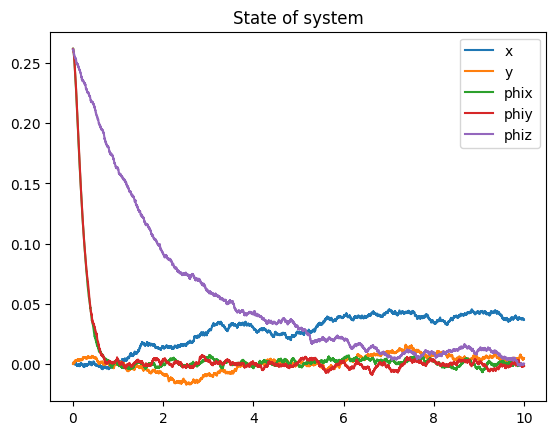

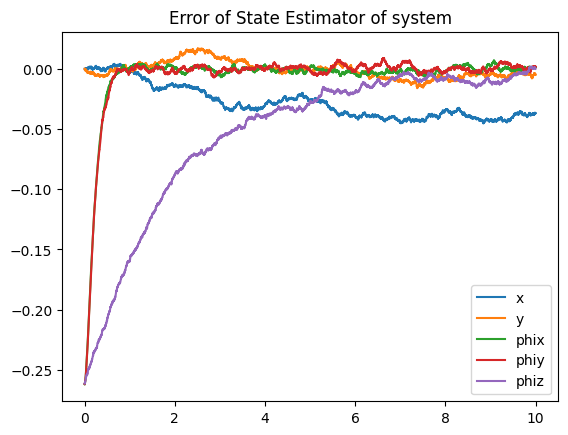

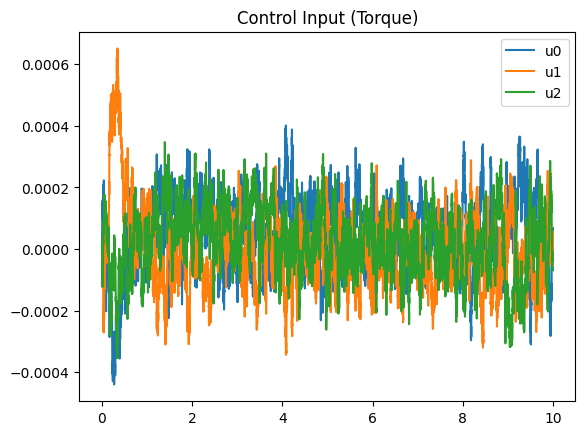

In [178]:
plt.title("State of system")
plt.plot(ts, xs[:,0], label="x")
plt.plot(ts, xs[:,1], label="y")
plt.plot(ts, xs[:,2], label="phix")
plt.plot(ts, xs[:,3], label="phiy")
plt.plot(ts, xs[:,4], label="phiz")
plt.legend()
plt.show()

plt.title("Error of State Estimator of system")
plt.plot(ts, xhats[:,0] - xs[:,0], label="x")
plt.plot(ts, xhats[:,1] - xs[:,1], label="y")
plt.plot(ts, xhats[:,2] - xs[:,2], label="phix")
plt.plot(ts, xhats[:,3] - xs[:,3], label="phiy")
plt.plot(ts, xhats[:,4] - xs[:,4], label="phiz")
plt.legend()
plt.show()

plt.title("Control Input (Torque)")
plt.plot(ts, us[:,0], label="u0")
plt.plot(ts, us[:,1], label="u1")
plt.plot(ts, us[:,2], label="u2")
plt.legend()
plt.show()